In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf

In [2]:
general_path = 'data/'
df = pd.read_csv(general_path + 'train.csv')
df.sample(5)

,image_id,label
11453,3045897535.jpg,3
95,1016334938.jpg,3
4761,1848723275.jpg,2
3415,1598014441.jpg,3
14853,3664478040.jpg,4


In [3]:
train_list = df.to_numpy()
image_list = train_list[:,0].astype(np.str)
label_list = train_list[:,1].astype(np.uint8)
data_list = np.column_stack((image_list, label_list))

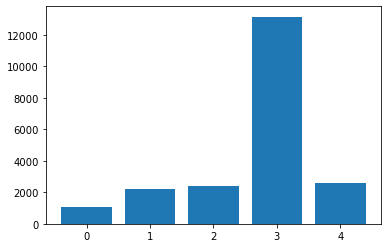

In [4]:
import matplotlib.pyplot as plt
plt.hist(label_list, bins=np.arange(6)-0.5, density=False, cumulative=False, histtype='bar', rwidth=0.8)
plt.xticks(range(5))
plt.show()

In [5]:
def get_leaf_data(train_list):
    '''
        train_list[:][0] : image's file name
        train_list[:][1] : image's label
    '''
    height = 456
    width = 456
    
    length = train_list.shape[0]
    ori_list = np.arange(length)
    aug_list = np.random.choice(ori_list, length, replace=True)
    
    np.random.shuffle(ori_list)
    np.random.shuffle(aug_list)
    
    zeros = np.zeros(length)
    ones = np.ones(length)
    is_aug = np.append(zeros, ones)
    
    total_list = np.append(ori_list, aug_list)
    total_list = np.column_stack((total_list, is_aug)).astype(np.int32)
    np.random.shuffle(total_list)
    
    for num, aug in total_list:
        if aug == 0:
            ori_img = tf.io.read_file(general_path + 'train_images/' + train_list[num][0].decode('utf-8'))
            ori_img = tf.image.decode_jpeg(ori_img, channels=3)
            img = tf.image.resize(ori_img, [456, 456])

            label = int(train_list[num][1])
            n_values = 5
            one_hot = tf.eye(n_values)[label]

            yield (tf.reshape(img, [1, height, width, 3]) / 255, tf.reshape(one_hot, [1, 5]))
            
        else:
            """
                1) crop
                2) rotate90
                3) flip(horizon, vertical)
                4) hue
                5) brightness
                6) constrast
                7) clip
            """
            rc = np.random.randint(0, 300)
            rr = np.random.randint(0, 3)
            
            # load a image
            ori_img = tf.io.read_file(general_path + 'train_images/' + train_list[num][0].decode('utf-8'))
            
            # decode a raw image
            ori_img = tf.image.decode_jpeg(ori_img, channels=3)
            
            img_height, img_width, _ = ori_img.shape
            
            # 1) crop
            img = tf.image.random_crop(ori_img, [img_height - rc, img_height - rc, 3])
            
            # 2) rotate90
            img = tf.image.rot90(img, k=rr)
            
            # 3) flip(horizon, vertical)
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_flip_up_down(img)
            
            # 4) hue
            img = tf.image.random_hue(img, 0.1)
            
            # 5) brightness
            img = tf.image.random_brightness(img, 0.3)
            
            # 6) contrast
            img = tf.image.random_contrast(img, 0.6, 1.8)
            
            # 7) clip
            img = tf.clip_by_value(img, 0, 255)
            
            img = tf.image.resize(img, [456, 456])
            
            # one-hot encoding
            label = int(train_list[num][1])
            n_values = 5
            one_hot = tf.eye(n_values)[label]

            yield (tf.reshape(img, [1, height, width, 3]) / 255, tf.reshape(one_hot, [1, 5]))

In [6]:
def get_leaf_data_val(val_list):
    height = 456
    width = 456
    
    for image_name, label in val_list:
        ori_img = tf.io.read_file(general_path + 'train_images/' + image_name.decode('utf-8'))
        ori_img = tf.image.decode_jpeg(ori_img, channels=3)
        img = tf.image.resize(ori_img, [456, 456])

        label = int(label)
        n_values = 5
        one_hot = tf.eye(n_values)[label]
 
        yield (tf.reshape(img, [1, height, width, 3]) / 255, tf.reshape(one_hot, [1, 5]))

In [7]:
# *** Test code ***

# rc = np.random.randint(0, 300)
# rr = np.random.randint(0, 3)
# ori_img = tf.io.read_file(general_path + 'train_images/' + '85453943.jpg')
# ori_img = tf.image.decode_jpeg(ori_img, channels=3)
# img_height, img_width, _ = ori_img.shape
# img = tf.image.random_crop(ori_img, [img_height - rc, img_height - rc, 3])
# img = tf.image.rot90(img, k=rr)
# img = tf.image.random_flip_left_right(img)
# img = tf.image.random_flip_up_down(img)
# img = tf.image.random_hue(img, 0.1)
# img = tf.image.random_brightness(img, 0.15)
# img = tf.image.random_contrast(img, 0.8, 1.5)

# img = tf.clip_by_value(img, 0, 255)
# img = tf.image.resize(img, [456, 456])

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.axis('off')
# plt.imshow(img / 255)
# plt.title('augmented image')

# plt.subplot(1, 2, 2)
# plt.axis('off')
# plt.imshow(ori_img)
# plt.title('original image')

# plt.show()
# print(tf.math.reduce_max(augmented_img))
# print(tf.math.reduce_min(augmented_img))
# print(tf.math.maximum(tf.reshape(augmented_img, [456*456*3])))

In [8]:
inputs = tf.keras.layers.Input(shape=(456, 456, 3))

effnet = tf.keras.applications.EfficientNetB5(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling='avg', classes=5,
    classifier_activation='softmax'
)(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(effnet)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(top_dropout_rate, name='top_dropout')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', name='pred')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()

In [10]:
# split train_validation

np.random.shuffle(data_list)
split_ratio = int(data_list.shape[0]*0.8)
train_list = data_list[:split_ratio]
val_list = data_list[split_ratio:]

In [11]:
# checkpoint

checkpoint_path = "data/checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=1)

model.save_weights(checkpoint_path.format(epoch=0))

In [12]:
dataset = tf.data.Dataset.from_generator(get_leaf_data,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([None, 456, 456, 3], [None, 5]),
                                         args=(train_list, ))

val = tf.data.Dataset.from_generator(get_leaf_data_val,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([None, 456, 456, 3], [None, 5]),
                                         args=(val_list, ))

In [ ]:
hist = model.fit(dataset, validation_data=val, callbacks=[cp_callback], epochs=20)

Epoch 1/20
  34234/Unknown - 5797s 169ms/step - loss: 0.7328 - acc: 0.7294
Epoch 00001: saving model to data/checkpoint\cp-0001.ckpt
34234/34234 [==============================] - 5969s 174ms/step - loss: 0.7328 - acc: 0.7294 - val_loss: 1.7435 - val_acc: 0.4951
Epoch 2/20
34234/34234 [==============================] - ETA: 0s - loss: 0.4758 - acc: 0.8305
Epoch 00002: saving model to data/checkpoint\cp-0002.ckpt
34234/34234 [==============================] - 5970s 174ms/step - loss: 0.4758 - acc: 0.8305 - val_loss: 2.4087 - val_acc: 0.5626
Epoch 3/20
34234/34234 [==============================] - ETA: 0s - loss: 0.3996 - acc: 0.8601
Epoch 00003: saving model to data/checkpoint\cp-0003.ckpt
34234/34234 [==============================] - 5913s 173ms/step - loss: 0.3996 - acc: 0.8601 - val_loss: 2.6122 - val_acc: 0.5699
Epoch 4/20
34234/34234 [==============================] - ETA: 0s - loss: 0.3506 - acc: 0.8794
Epoch 00004: saving model to data/checkpoint\cp-0004.ckpt
34234/34234 [=====